In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm  # notebook compatible
import torch
from torch import nn
from torch.functional import F
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from mcts import MCTS_AlphaZero
from mcts_utils import ReplayMemory, compute_returns, train_on_batch
%load_ext scalene

/home/luke/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


In [2]:
# Tools to train model
class DenseMCTSNet(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.n_actions = env.action_space.n
        self.network = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
        )

        self.policy_head = nn.Linear(128, self.n_actions) 
        self.value_head = nn.Linear(128, 1)
    
    def forward(self, x):
        x = self.network(x)
        logits = self.policy_head(x)
        return nn.functional.softmax(logits, dim=-1), self.value_head(x)
    
    def logits(self, x):
        x = self.network(x)
        return self.policy_head(x)

def episode(env, network, memory, config):
    # Run network in evaluation mode
    network.eval()

    obs = env.reset()
    done = False

    rewards = []
    logits = []
    ep_obs = []
    # mcts = MCTS_AlphaZero(obs, model, network, config)
    while not done:
        action, pi = MCTS_AlphaZero(obs, env, network, config).search()
        # action, pi = mcts.search()
        ep_obs.append(obs)
        logits.append(pi)

        obs, r, done, _ = env.step(action)

        # Reuse Search Tree
        # mcts.forward(action)
        rewards.append(r)

    returns = compute_returns(rewards, config["discount"])

    for i in range(len(returns)):
        memory.store_transition(ep_obs[i], logits[i], returns[i])
    
    return sum(rewards), len(rewards)

def policy_iteration(env, network, config):
    writer = SummaryWriter(config["log_path"])
    memory = ReplayMemory(config["memory_size"], env)
    optimizer = torch.optim.Adam(network.parameters(), lr=config["learning_rate"], weight_decay=1e-4)
    pbar = tqdm(range(config["training_steps"]))
    total_rewards = 0
    for global_step in pbar:
        ep_rewards, ep_length = episode(env, network, memory, config)
        total_rewards += ep_rewards

        # Only train once buffer large enough, and rewards to learn with
        for _ in range(config["epochs"]):
            batch = memory.sample_batch(config["batch_size"])
            vloss, ploss = train_on_batch(network, optimizer, batch, global_step, writer) 


        if global_step % 5 == 0:
            writer.add_scalar("losses/loss", (ploss + vloss).mean().item(), global_step)
            writer.add_scalar("losses/policy_loss", ploss.mean().item(), global_step)
            writer.add_scalar("losses/value_loss", vloss.mean().item(), global_step)
        
        if (global_step % config["checkpoint_freq"] == 0):
            torch.save(network.state_dict(), config["checkpoint_path"] + f"model_{global_step}.pt")
        
        writer.add_scalar("Success Rate", total_rewards / (global_step + 1), global_step)
        writer.add_scalar("Episode Length", ep_length, global_step)
        pbar.set_description(f"Memory size: {memory.counter}, Cumulative rewards: {total_rewards}")
    return network

lake_actions = {
    0: "LEFT",
    1: "DOWN", 
    2: "RIGHT",
    3: "UP"
}

room_actions = {
    0: "left",
    1: "right",
    2: "forward",
    3: "pickup",
    4: "drop",
    5: "toggle",
    6: "done" 
}

DEFAULT_CONFIG = {
    "training_steps": 200,
    "batch_size": 256,
    "learning_rate": 1e-4,
    "memory_size": 1000,
    "discount": 0.9,
    "search_iters": 20,
    "checkpoint_freq": 50000,
    "epochs": 20,
    "checkpoint_path": "./frozen_lake/",
    "log_path": "./frozen_lake/"
}

In [3]:
env = gym.make("FrozenLake-v1", is_slippery=False)
env._max_episode_steps = 20
net = DenseMCTSNet(env)
policy_iteration(env, net, DEFAULT_CONFIG)

Memory size: 755, Cumulative rewards: 72.0: 100%|██████████| 200/200 [00:52<00:00,  3.83it/s]


DenseMCTSNet(
  (network): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
  )
  (policy_head): Linear(in_features=128, out_features=4, bias=True)
  (value_head): Linear(in_features=128, out_features=1, bias=True)
)

Text(0.5, 1.0, 'Value function')

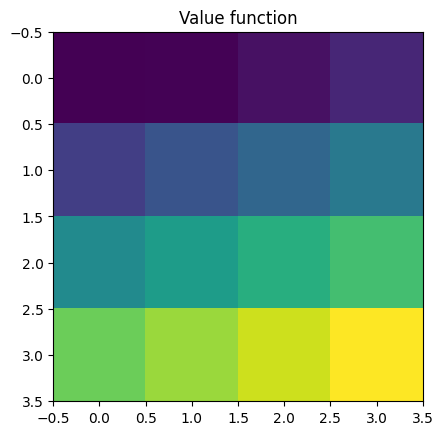

In [7]:
fresh_net = DenseMCTSNet(env)
grid= np.zeros((4, 4))
for i in range(16):
    grid[np.unravel_index(i, (4,4))] += fresh_net(torch.Tensor([i]))[1].detach().numpy()
plt.imshow(grid)
plt.title("Value function")


Text(0.5, 1.0, 'Value function')

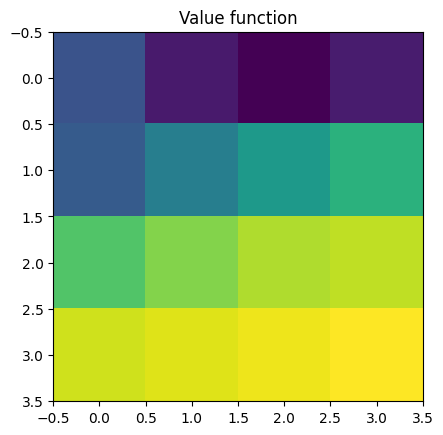

In [8]:
grid = np.zeros((4, 4))
for i in range(16):
    grid[np.unravel_index(i, (4,4))] += net(torch.Tensor([i]))[1].detach().numpy()
plt.imshow(grid)
plt.title("Value function")

[0, 4, 8, 9, 13, 14, 15]
[0.531441 0.59049  0.6561   0.729    0.81     0.9      1.      ]
0 DOWN
4 RIGHT
8 RIGHT
9 RIGHT
13 RIGHT
14 RIGHT
15 RIGHT


Text(0.5, 1.0, 'Value function')

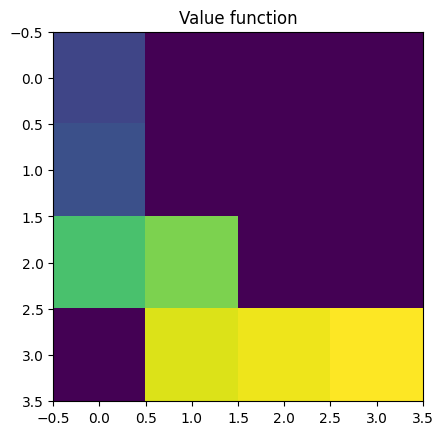

In [11]:
obs = env.reset()
ep_obs = [obs]
rewards = [0]
done = False
while not done:
    action, pi = MCTS_AlphaZero(obs, env, net, DEFAULT_CONFIG).search()
    # action, pi = mcts.search()
    obs, r, done, _ = env.step(action)
    rewards.append(r)
    ep_obs.append(obs)

returns = compute_returns(rewards, 0.9)

print(ep_obs)
print(returns)

grid = np.zeros((4, 4))
for i,v in zip(ep_obs, returns):
    pi, v = net(torch.Tensor([i]))
    pi, v = pi.detach().numpy(), v.detach().numpy()
    grid[np.unravel_index(i, (4,4))] += v
    # print(pi)
    print(i, lake_actions[np.argmax(pi)])
    # grid[np.unravel_index(i, (4,4))] += v 
plt.imshow(grid)
plt.title("Value function")